#Melanoma Recognition


The goal of this project is visually diagnose melanoma, the deadliest form of skin cancer. In particular, our algorithm will distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).
![alt text](https://challenge.kitware.com/api/v1/file/5846467ecad3a51cc66c8dcd/download)

##Imports

In [5]:
!pip install scikit-plot

In [0]:
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
from PIL import Image


##Load data


Data used in this project was collected from:
*   https://challenge.kitware.com/#phase/5840f53ccad3a51cc66c8dab
*   https://challenge2018.isic-archive.com/task3/training/ (main source)
*   http://www.cs.rug.nl/~imaging/databases/melanoma_naevi/

First class contains pictures of melanoma. Benign lesions (nevi and seborrheic keratoses) were merged together to create the second class. Pictures with marks (pen dots, arrows, circles) were deleted from dataset.

In [10]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
for n in ['train.zip', 'valid.zip', 'test.zip']:
  zip_ref = zipfile.ZipFile("/content/drive/My Drive/data/" + n, 'r')
  zip_ref.extractall("/tmp/data")
  zip_ref.close()

##Define data loaders

In [0]:
data_dir = "/tmp/data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
test_dir = data_dir + "/test"

#mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#transforms for train phase with data augmentation - rotation, flips, resize
train_transforms = torchvision.transforms.Compose([torchvision.transforms.RandomRotation(90),
                                                   torchvision.transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
                                                   torchvision.transforms.RandomHorizontalFlip(),
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(mean, std)]) 

#transforms for test and validation phase
test_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(255),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean, std)])

#Load the datasets with ImageFolder
image_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = torchvision.datasets.ImageFolder(valid_dir, transform=test_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=test_transforms)

# Define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_dataset, batch_size=32, shuffle=True, num_workers=0)
testloaders = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=0)
validloaders = torch.utils.data.DataLoader(valid_dataset, batch_size=64, num_workers=0)

##Load pretrained model resnet
Change linear layer to match output to number of our classes = 2

In [7]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 46368500.69it/s]


In [35]:
# check if CUDA is available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


##Train model

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss()

In [0]:
model_save_path = "drive/My Drive/model_melanoma_v8.pt"


epoch: 1 / 20
trainings error: 0.8356253192538307
validation error: 1.0704101920127869
saving model...
epoch: 2 / 20
trainings error: 0.7465776744342986
validation error: 0.9659586946169535
saving model...
epoch: 3 / 20
trainings error: 0.6961875430175236
validation error: 0.8825737833976746
saving model...
epoch: 4 / 20
trainings error: 0.6340237974174439
validation error: 0.8122503360112509
saving model...
epoch: 5 / 20
trainings error: 0.6041028149544246
validation error: 0.7792836427688599
saving model...
epoch: 6 / 20
trainings error: 0.5657361040985773
validation error: 0.7545099854469299
saving model...
epoch: 7 / 20
trainings error: 0.5474434159104786
validation error: 0.7188821236292521
saving model...
epoch: 8 / 20
trainings error: 0.516103267196625
validation error: 0.687852164109548
saving model...
epoch: 9 / 20
trainings error: 0.4876857679041605
validation error: 0.6641738017400106
saving model...
epoch: 10 / 20
trainings error: 0.46903539839245023
validation error: 0.619

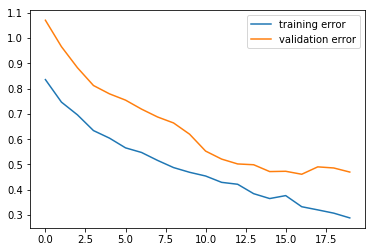

In [24]:
max_epochs = 20
trainings_error = []
validation_error = []
min_valid_error = 100
model_save_path = "drive/My Drive/model_melanoma_v8.pt"

model.to(device)

for epoch in range(max_epochs):
    print('epoch:', epoch+1, '/', max_epochs)
    count_train = 0
    trainings_error_tmp = []
    
    for data_sample, y in dataloaders:
        model.train()
        data_sample, y = data_sample.to(device), y.to(device)
        output = model(data_sample)
        err = criterion(output, y)
        err.backward()
        optimizer.step()
        trainings_error_tmp.append(err.item())
        
    mean_trainings_error = np.mean(trainings_error_tmp)
    trainings_error.append(mean_trainings_error)
    print('trainings error:', mean_trainings_error)

    model.eval()
    with torch.set_grad_enabled(False):
        validation_error_tmp = []

        for data_sample, y in validloaders:
            data_sample, y = data_sample.to(device), y.to(device)
            output = model(data_sample)
            err = criterion(output, y)
            validation_error_tmp.append(err.item())

        mean_val_error = np.mean(validation_error_tmp)
        validation_error.append(mean_val_error)
        print('validation error:', mean_val_error)
        #save best model
        if min_valid_error > mean_val_error:
          min_valid_error = mean_val_error
          torch.save(model.state_dict(), model_save_path)
          print('saving model...')

#plots for training and validation errors during training
plt.plot(trainings_error, label = 'training error')
plt.plot(validation_error, label = 'validation error')
plt.legend()
plt.show()

## Load best model 

In [11]:
#save current model 
# last_model_save_path = "drive/My Drive/model_melanoma_v7_last.pt"
# torch.save(model.state_dict(), last_model_save_path)
#load best model
model.load_state_dict(torch.load(model_save_path), strict=False)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

##Test

In [17]:
result_array = []
labels_array = []
prob_array = []

model.eval()
with torch.no_grad():
  test_error_tmp = []
  for data_sample, y in testloaders:
    data_sample, y = data_sample.to(device), y.to(device)
    output = model(data_sample)
    top_p, top_class = output.topk(1, dim=1)
    err = criterion(output, y)
    test_error_tmp.append(err.item())
    labels_array += y.tolist()
    result_array += top_class.flatten().tolist()
    prob_array += torch.nn.functional.softmax(output, dim=1).tolist()

mean_test_error = np.mean(test_error_tmp)
correct_results = np.array(result_array)==np.array(labels_array)
sum_correct = np.sum(correct_results)
accuracy = sum_correct/len(result_array)                    
print('Test accuracy: ', accuracy) 
print('Test error: ', mean_test_error)

Test accuracy:  0.7366666666666667
Test error:  0.6251504927873611


## Confusion Matrix and ROC curve


*   class 0 => melanoma 
*   class 1 => nevi 
*   class 3 =>seborrheic keratoses

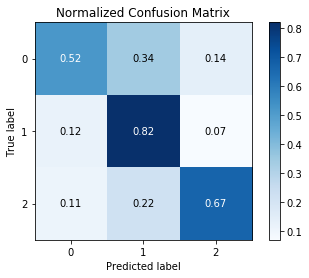

In [18]:
skplt.metrics.plot_confusion_matrix(labels_array, result_array, normalize=True)
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


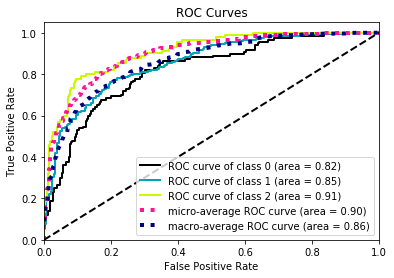

In [19]:
skplt.metrics.plot_roc_curve(labels_array, prob_array)
plt.show()

In [0]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img).to(device)
    image = image.float()
    return image

In [0]:
def predict(image, model):
    # Pass the image through our model
    output = model.forward(image)
    
    # Reverse the log function in our output
    output = torch.exp(output)
    
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

## Possible improvments


*   Lower treshold for classifing melanoma. It's better to have highier rate of true positive than false negative.
*   Try different pretrained models, try different learning parameters and transformations to get better accuracy.
*   Collect more training data (in our project we added new data only to melanoma class)
*   Check validation and test sets, current model can overfit on test data (error is lower than on validation data) or validation data is not representative sample of dataset

